# Отчет по проекту Intelligent Placer
Сердюков Дмитрий. 5030102/90401

In [ ]:
!pip install --user -r requirements.txt

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 1. Идентификация предметов
Для данной подзадачи я остановился на использовании предобученной сверточной нейронной сети YOLOv8

### 1.1 Датасет
Для таких небольших задач удобно использовать онлайн-сервис Roboflow, который позволяет удобно аннотировать данные и сгенерировать датасет

Исходные данные:
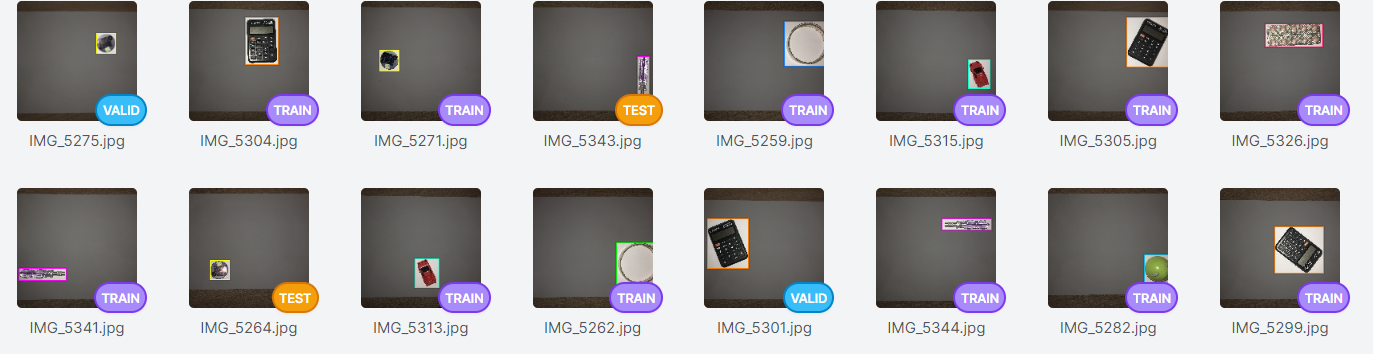

Суммарно:
- **_10 классов_**
- **_140 изображений_** 
- **_332 изображения_** (640x640) после применения аугментации


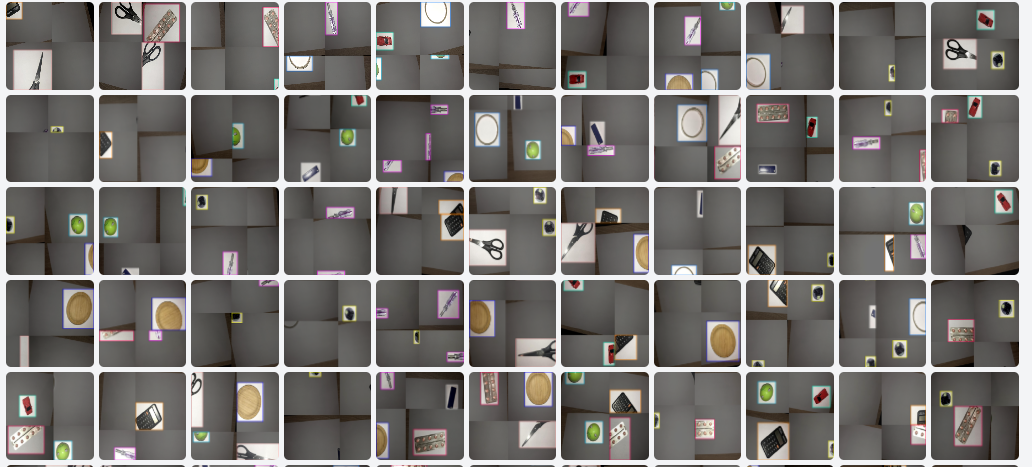

Аугментация подробнее:
- Outputs per training example: 3
- Flip: Horizontal, Vertical
- Rotation: Between -15° and +15°
- Saturation: Between -12% and +12%
- Brightness: Between -11% and +11%
- Mosaic: Applied

### 1.2 Обучение
Версия: YOLOv8l.pt <br>
Кол-во эпох (epochs): 100

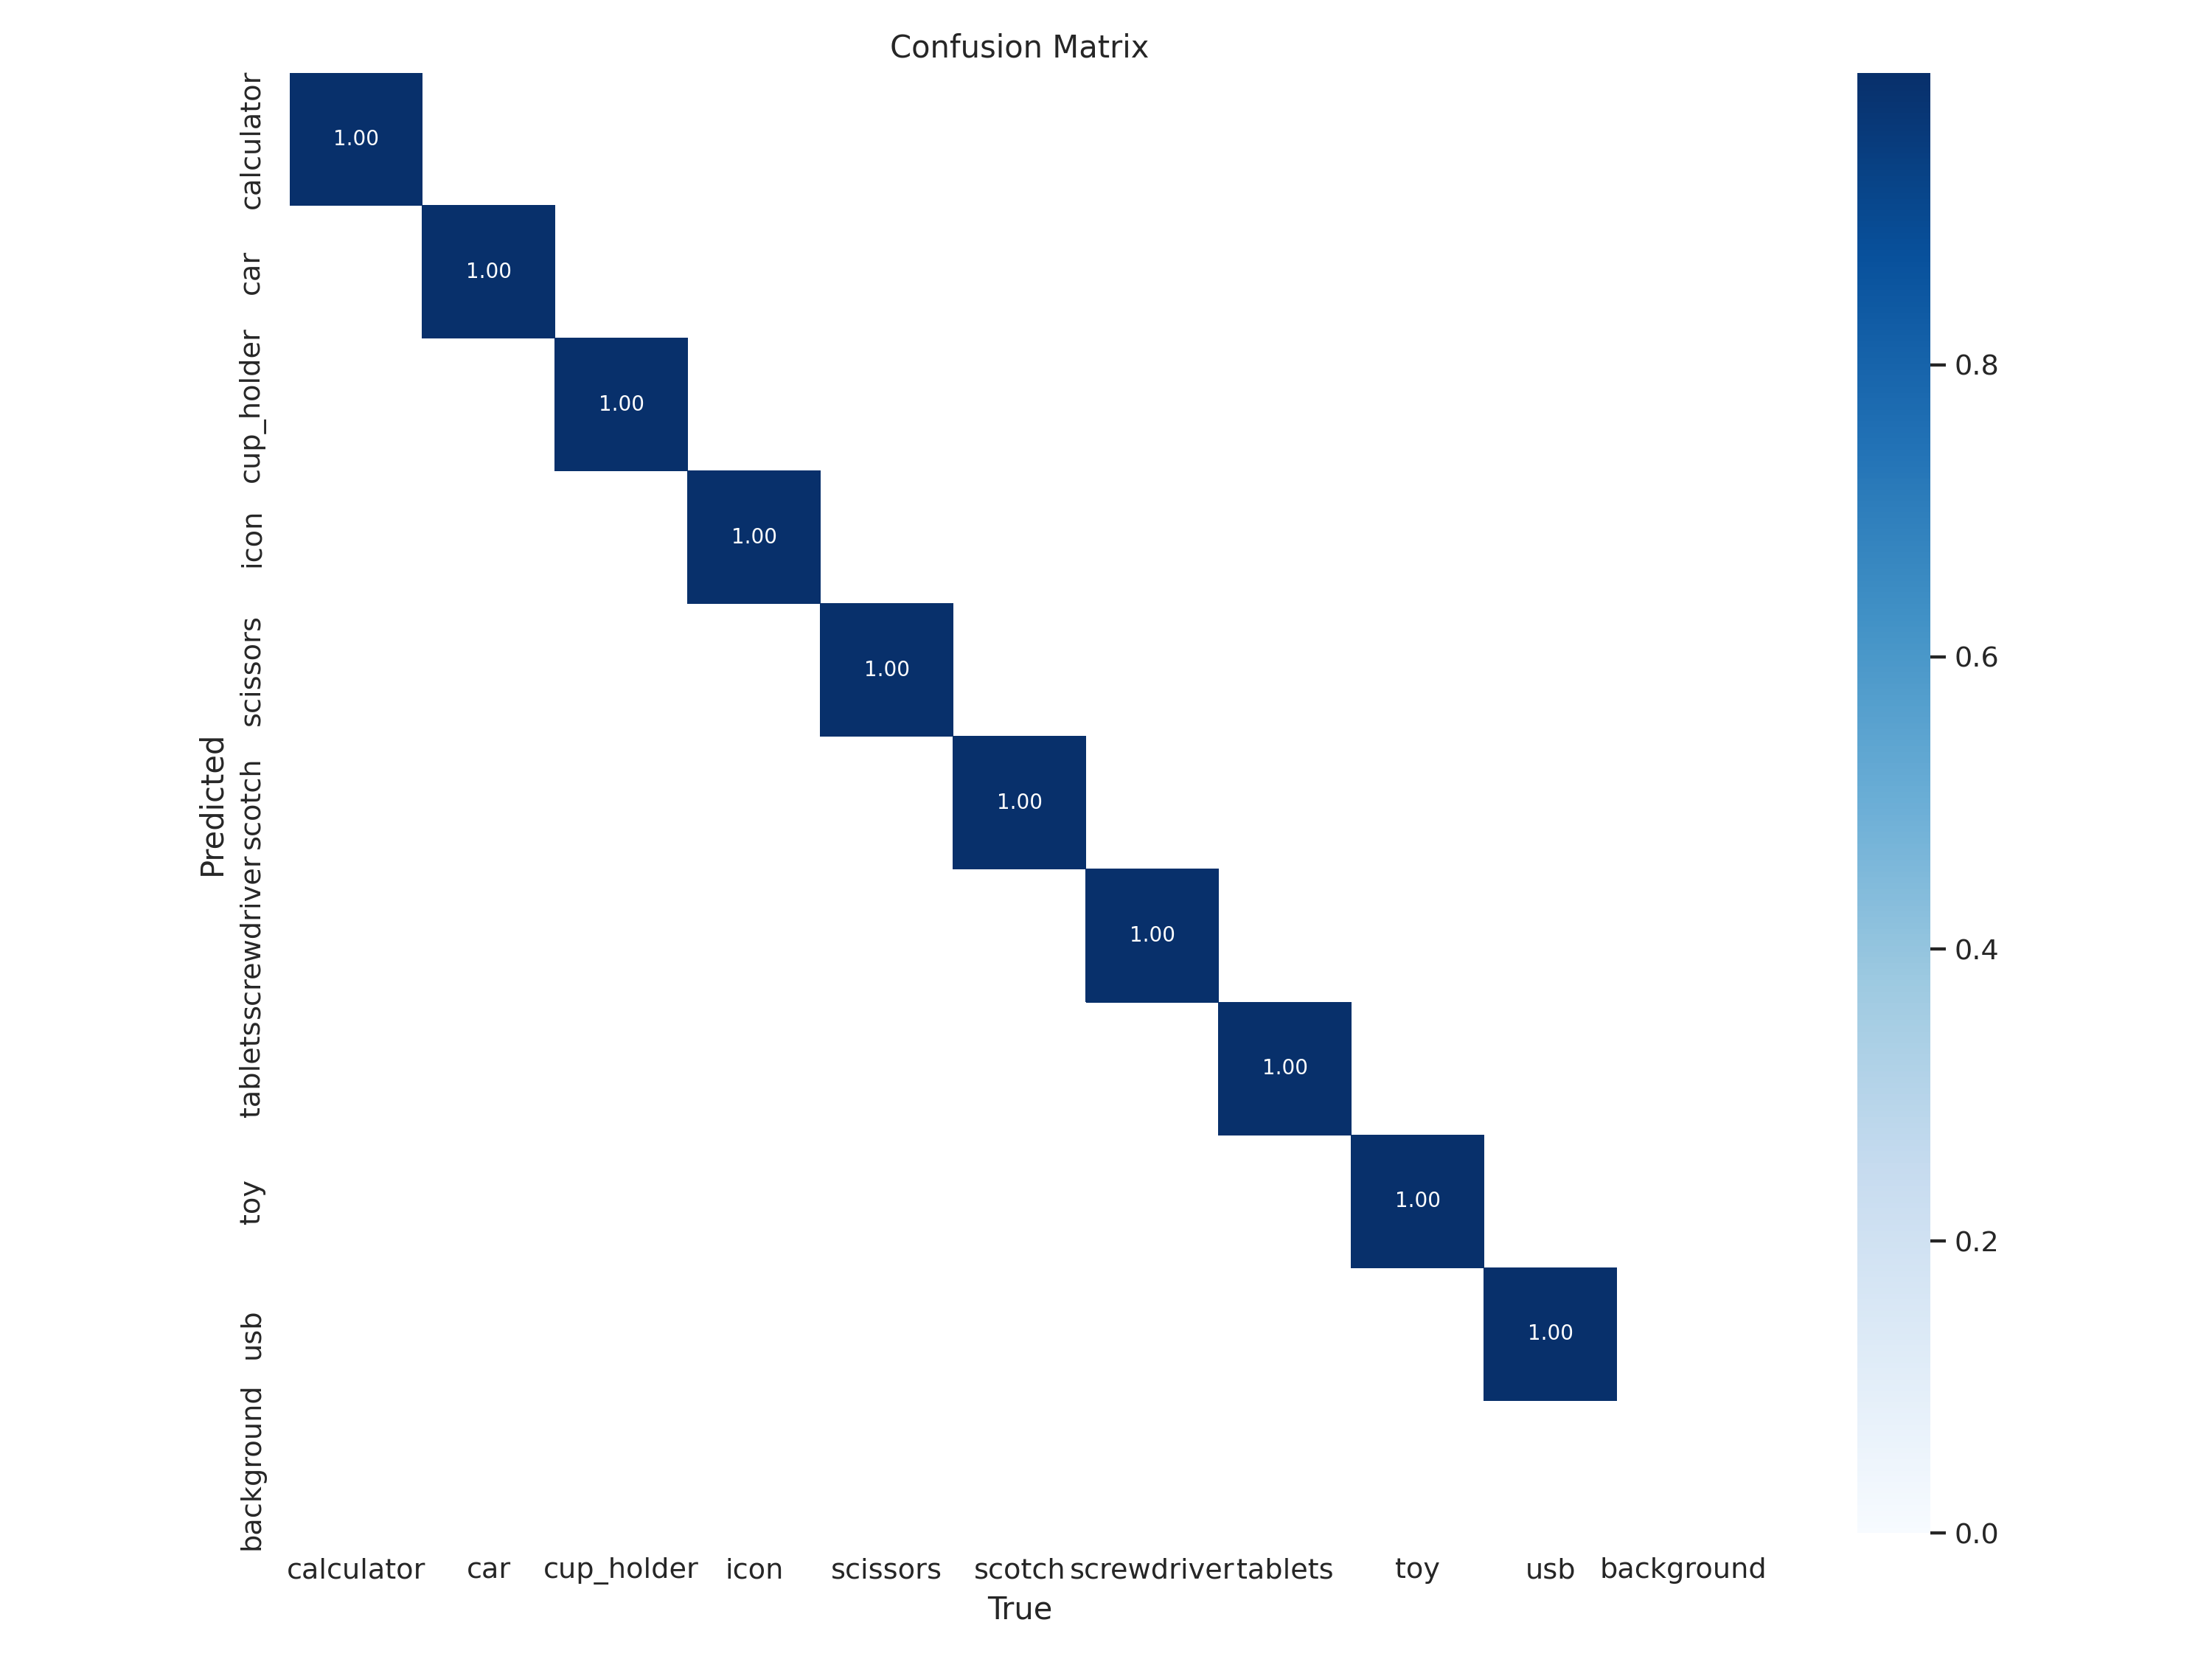

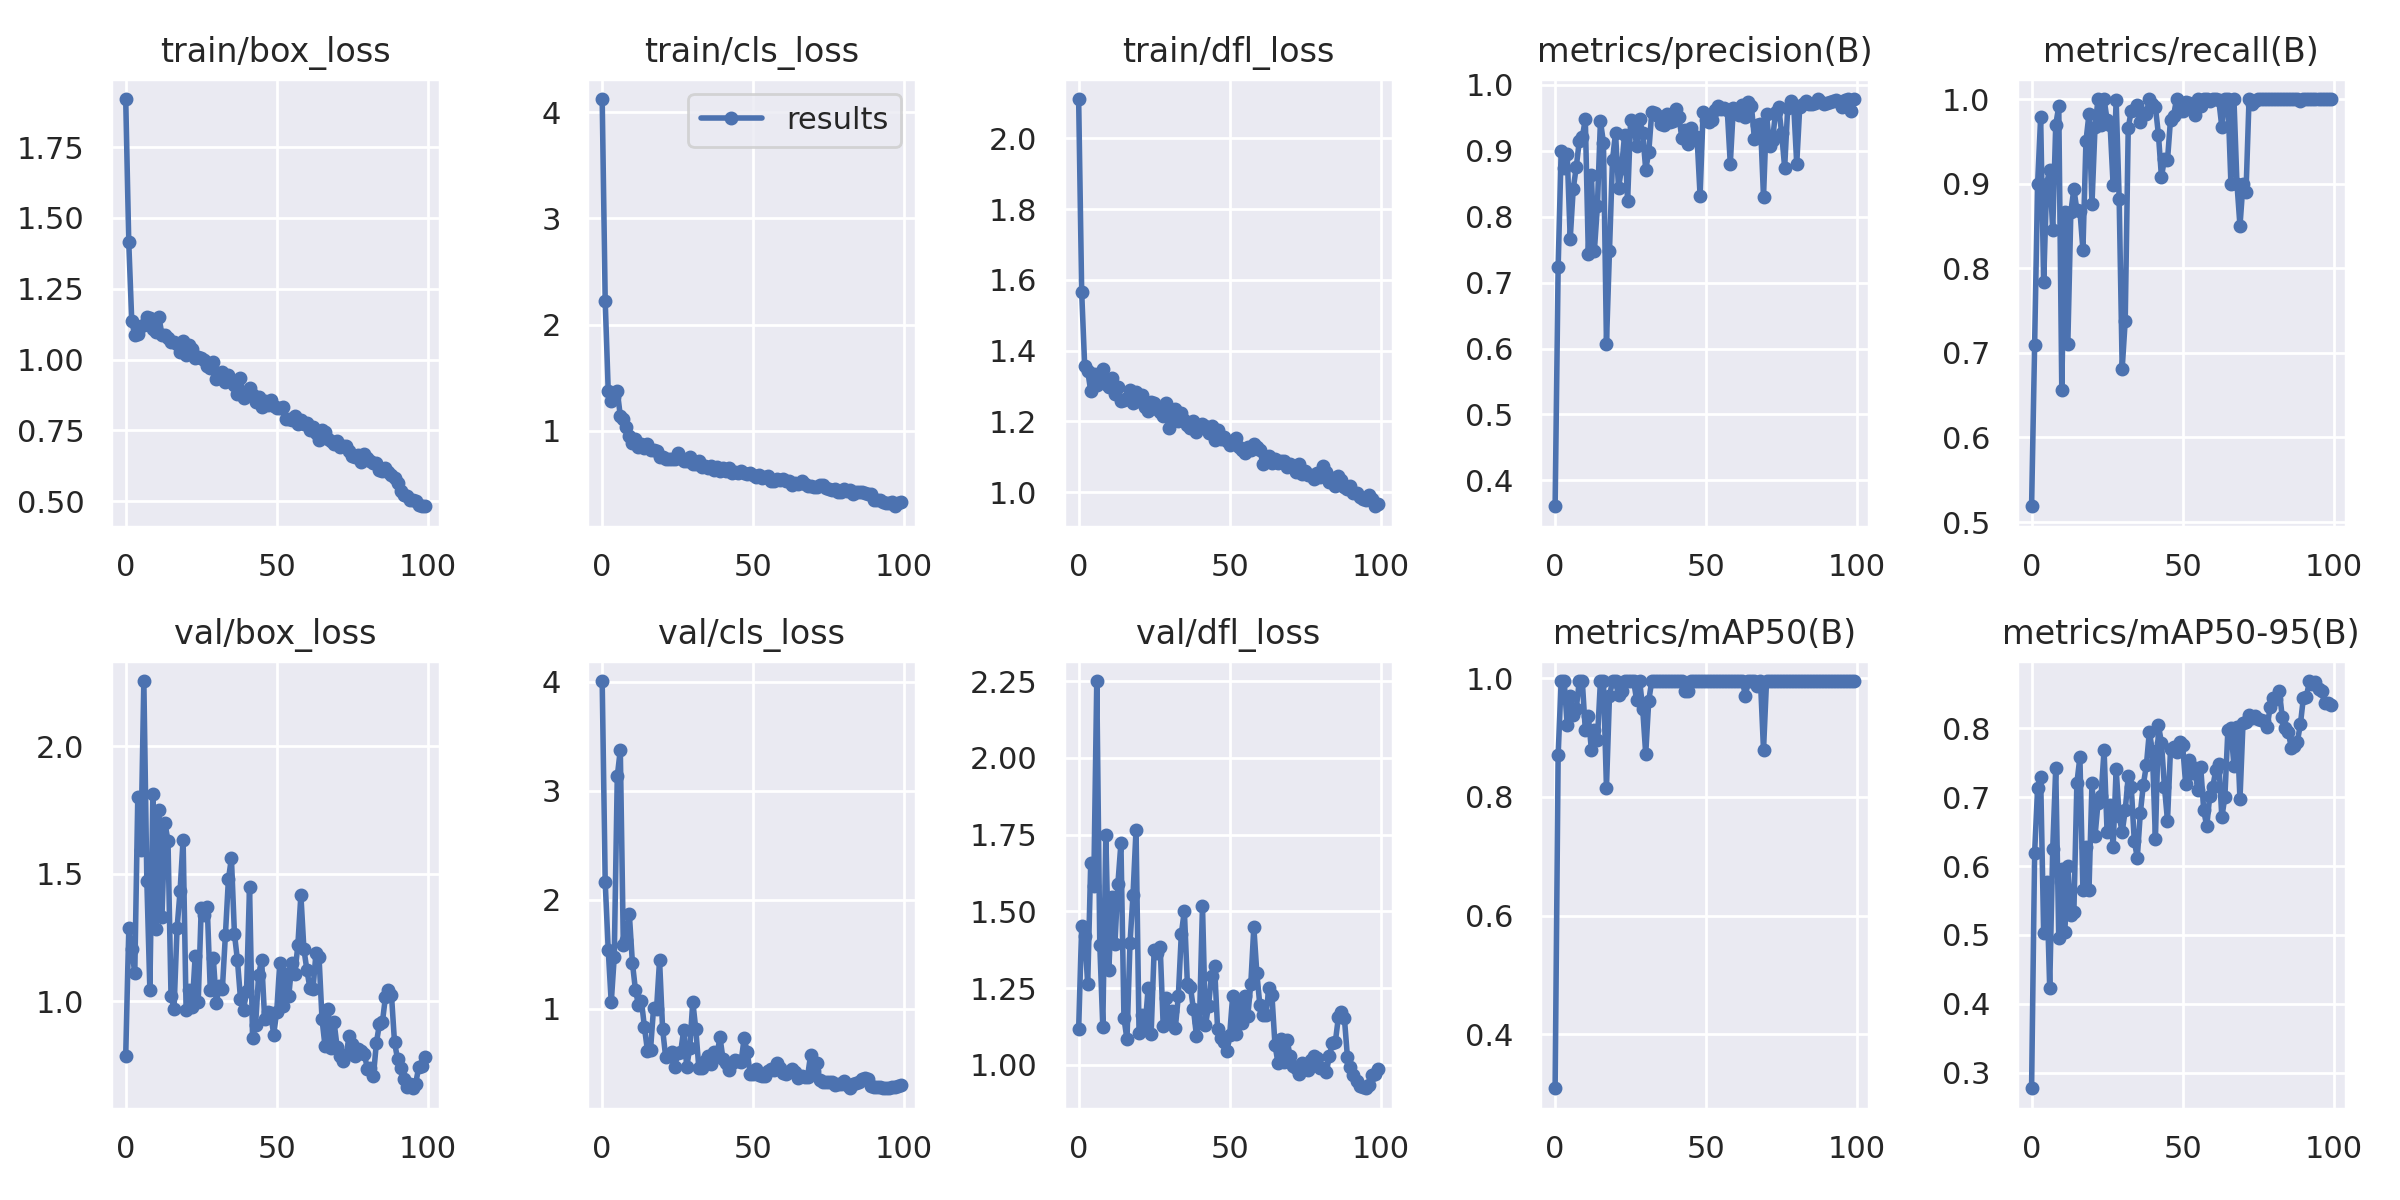

### 1.2.1 Результаты
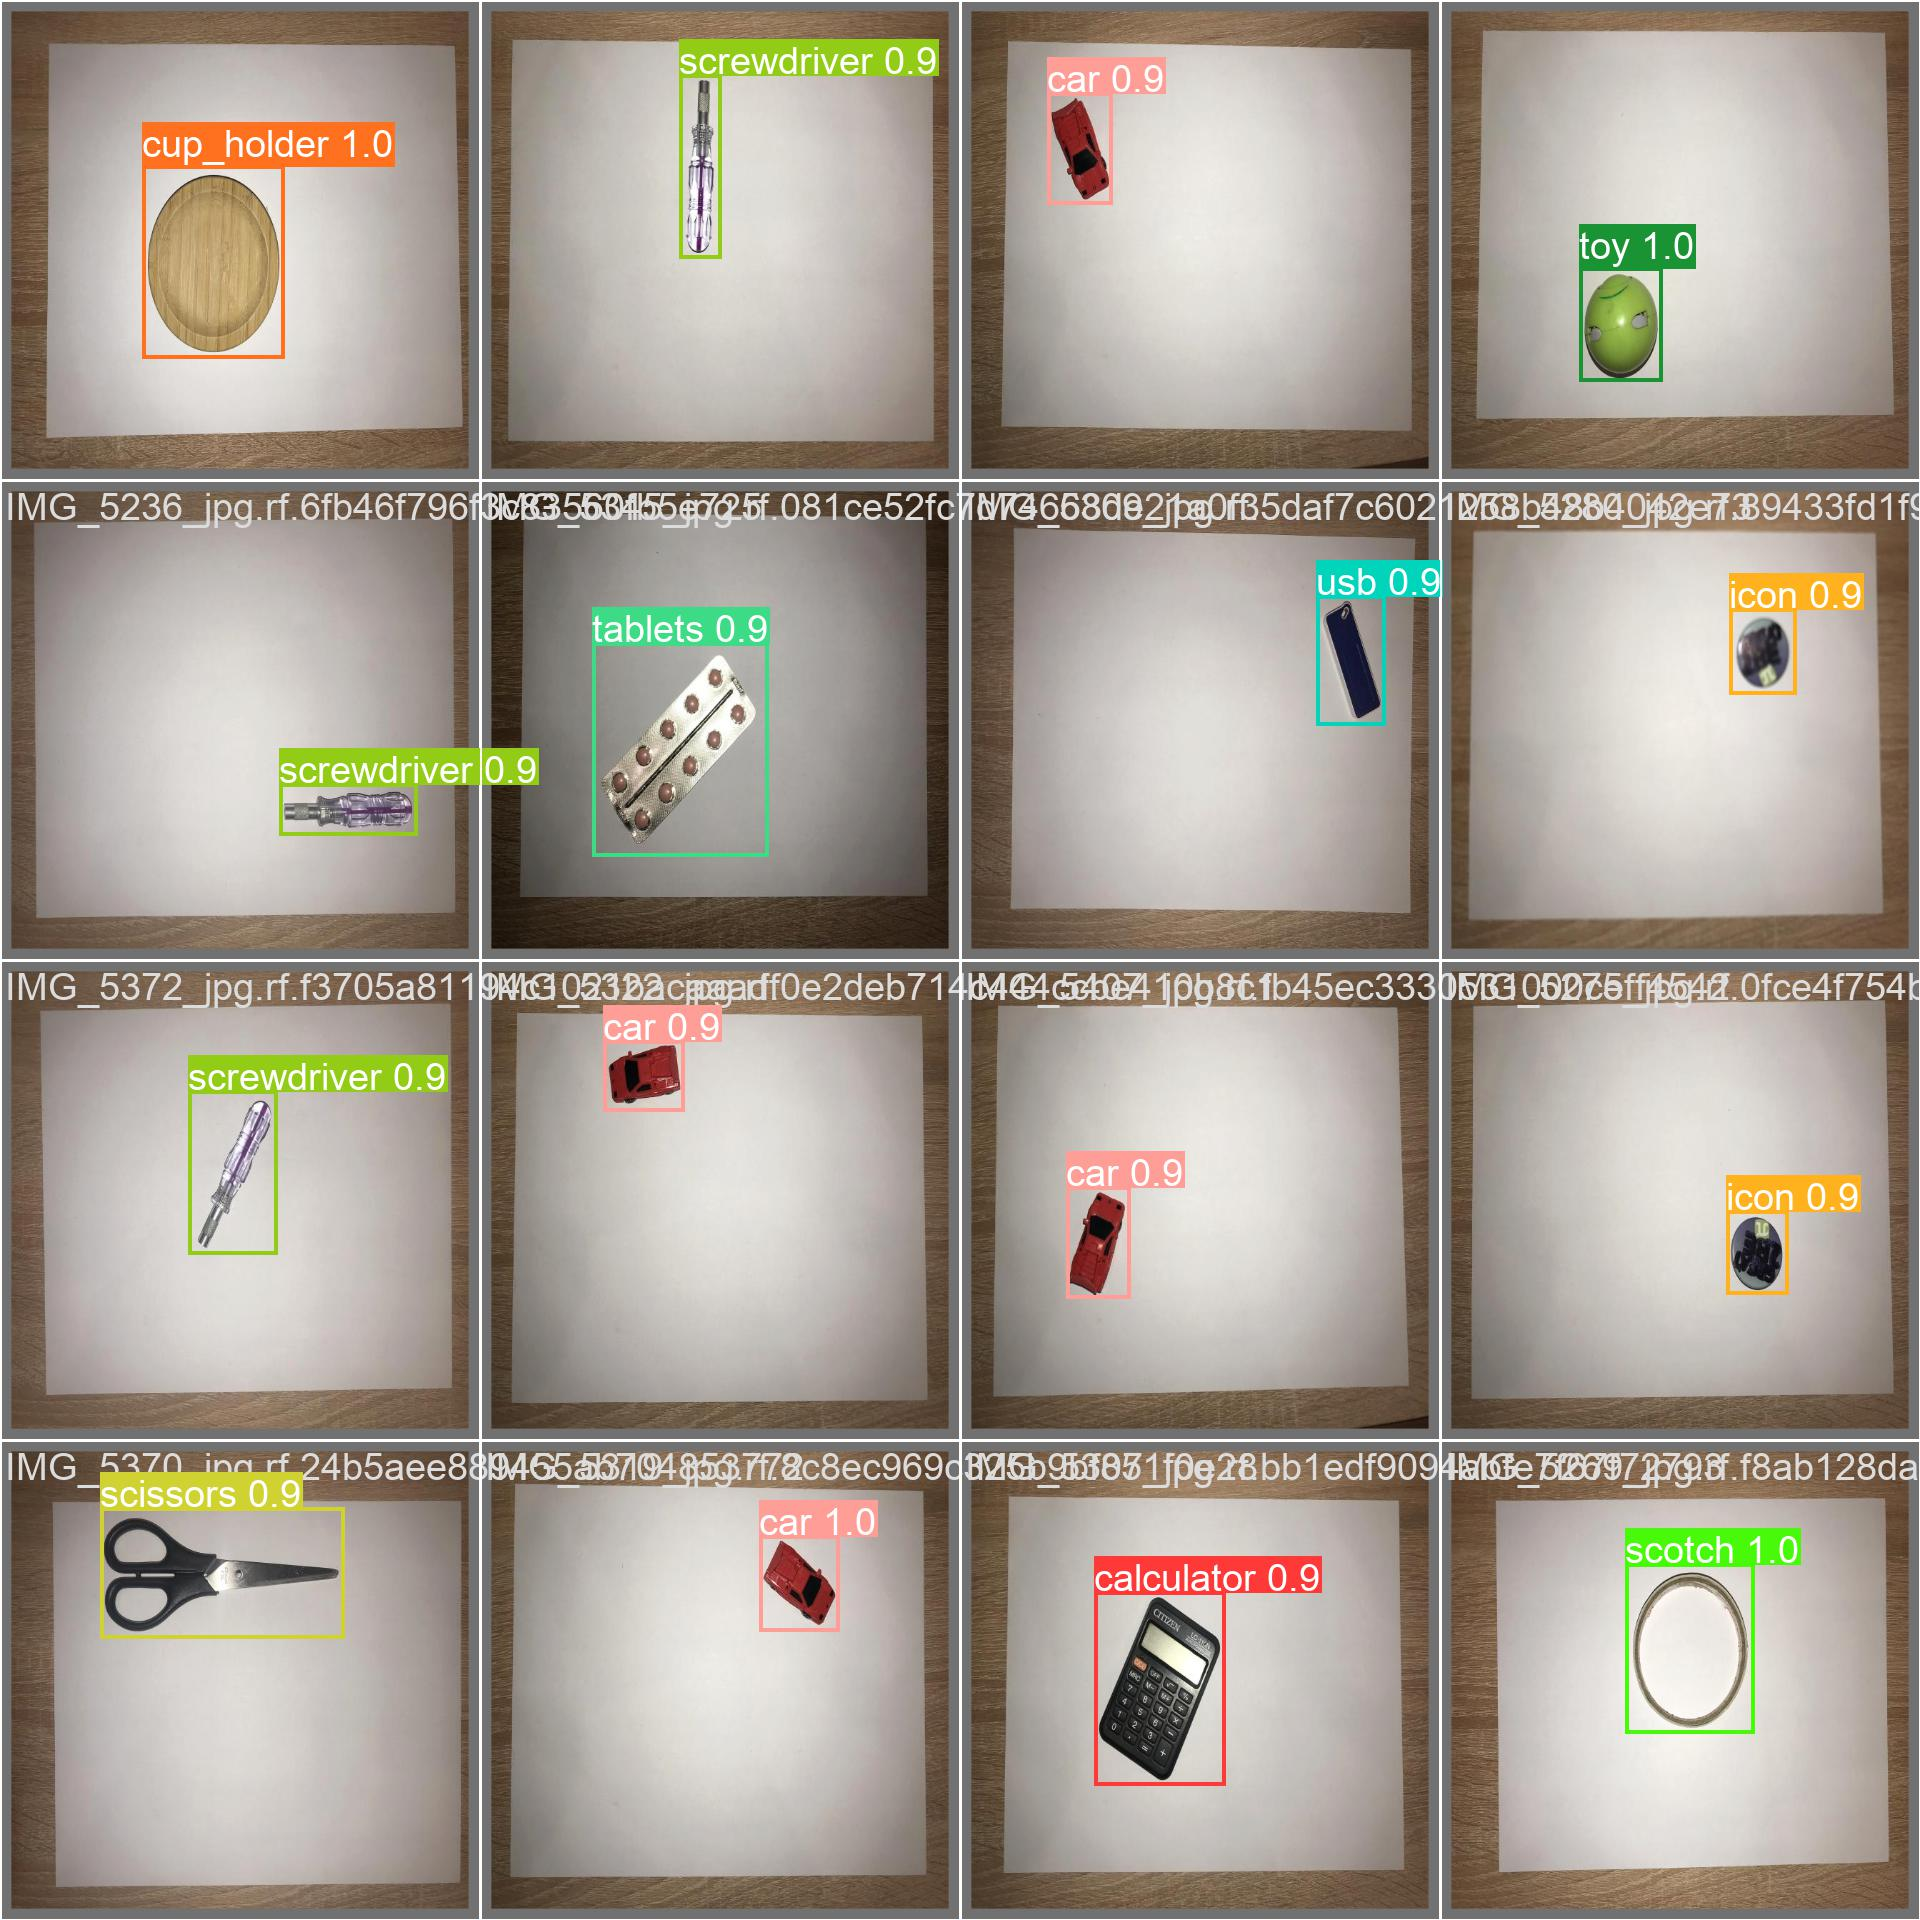

#### Сложный случай

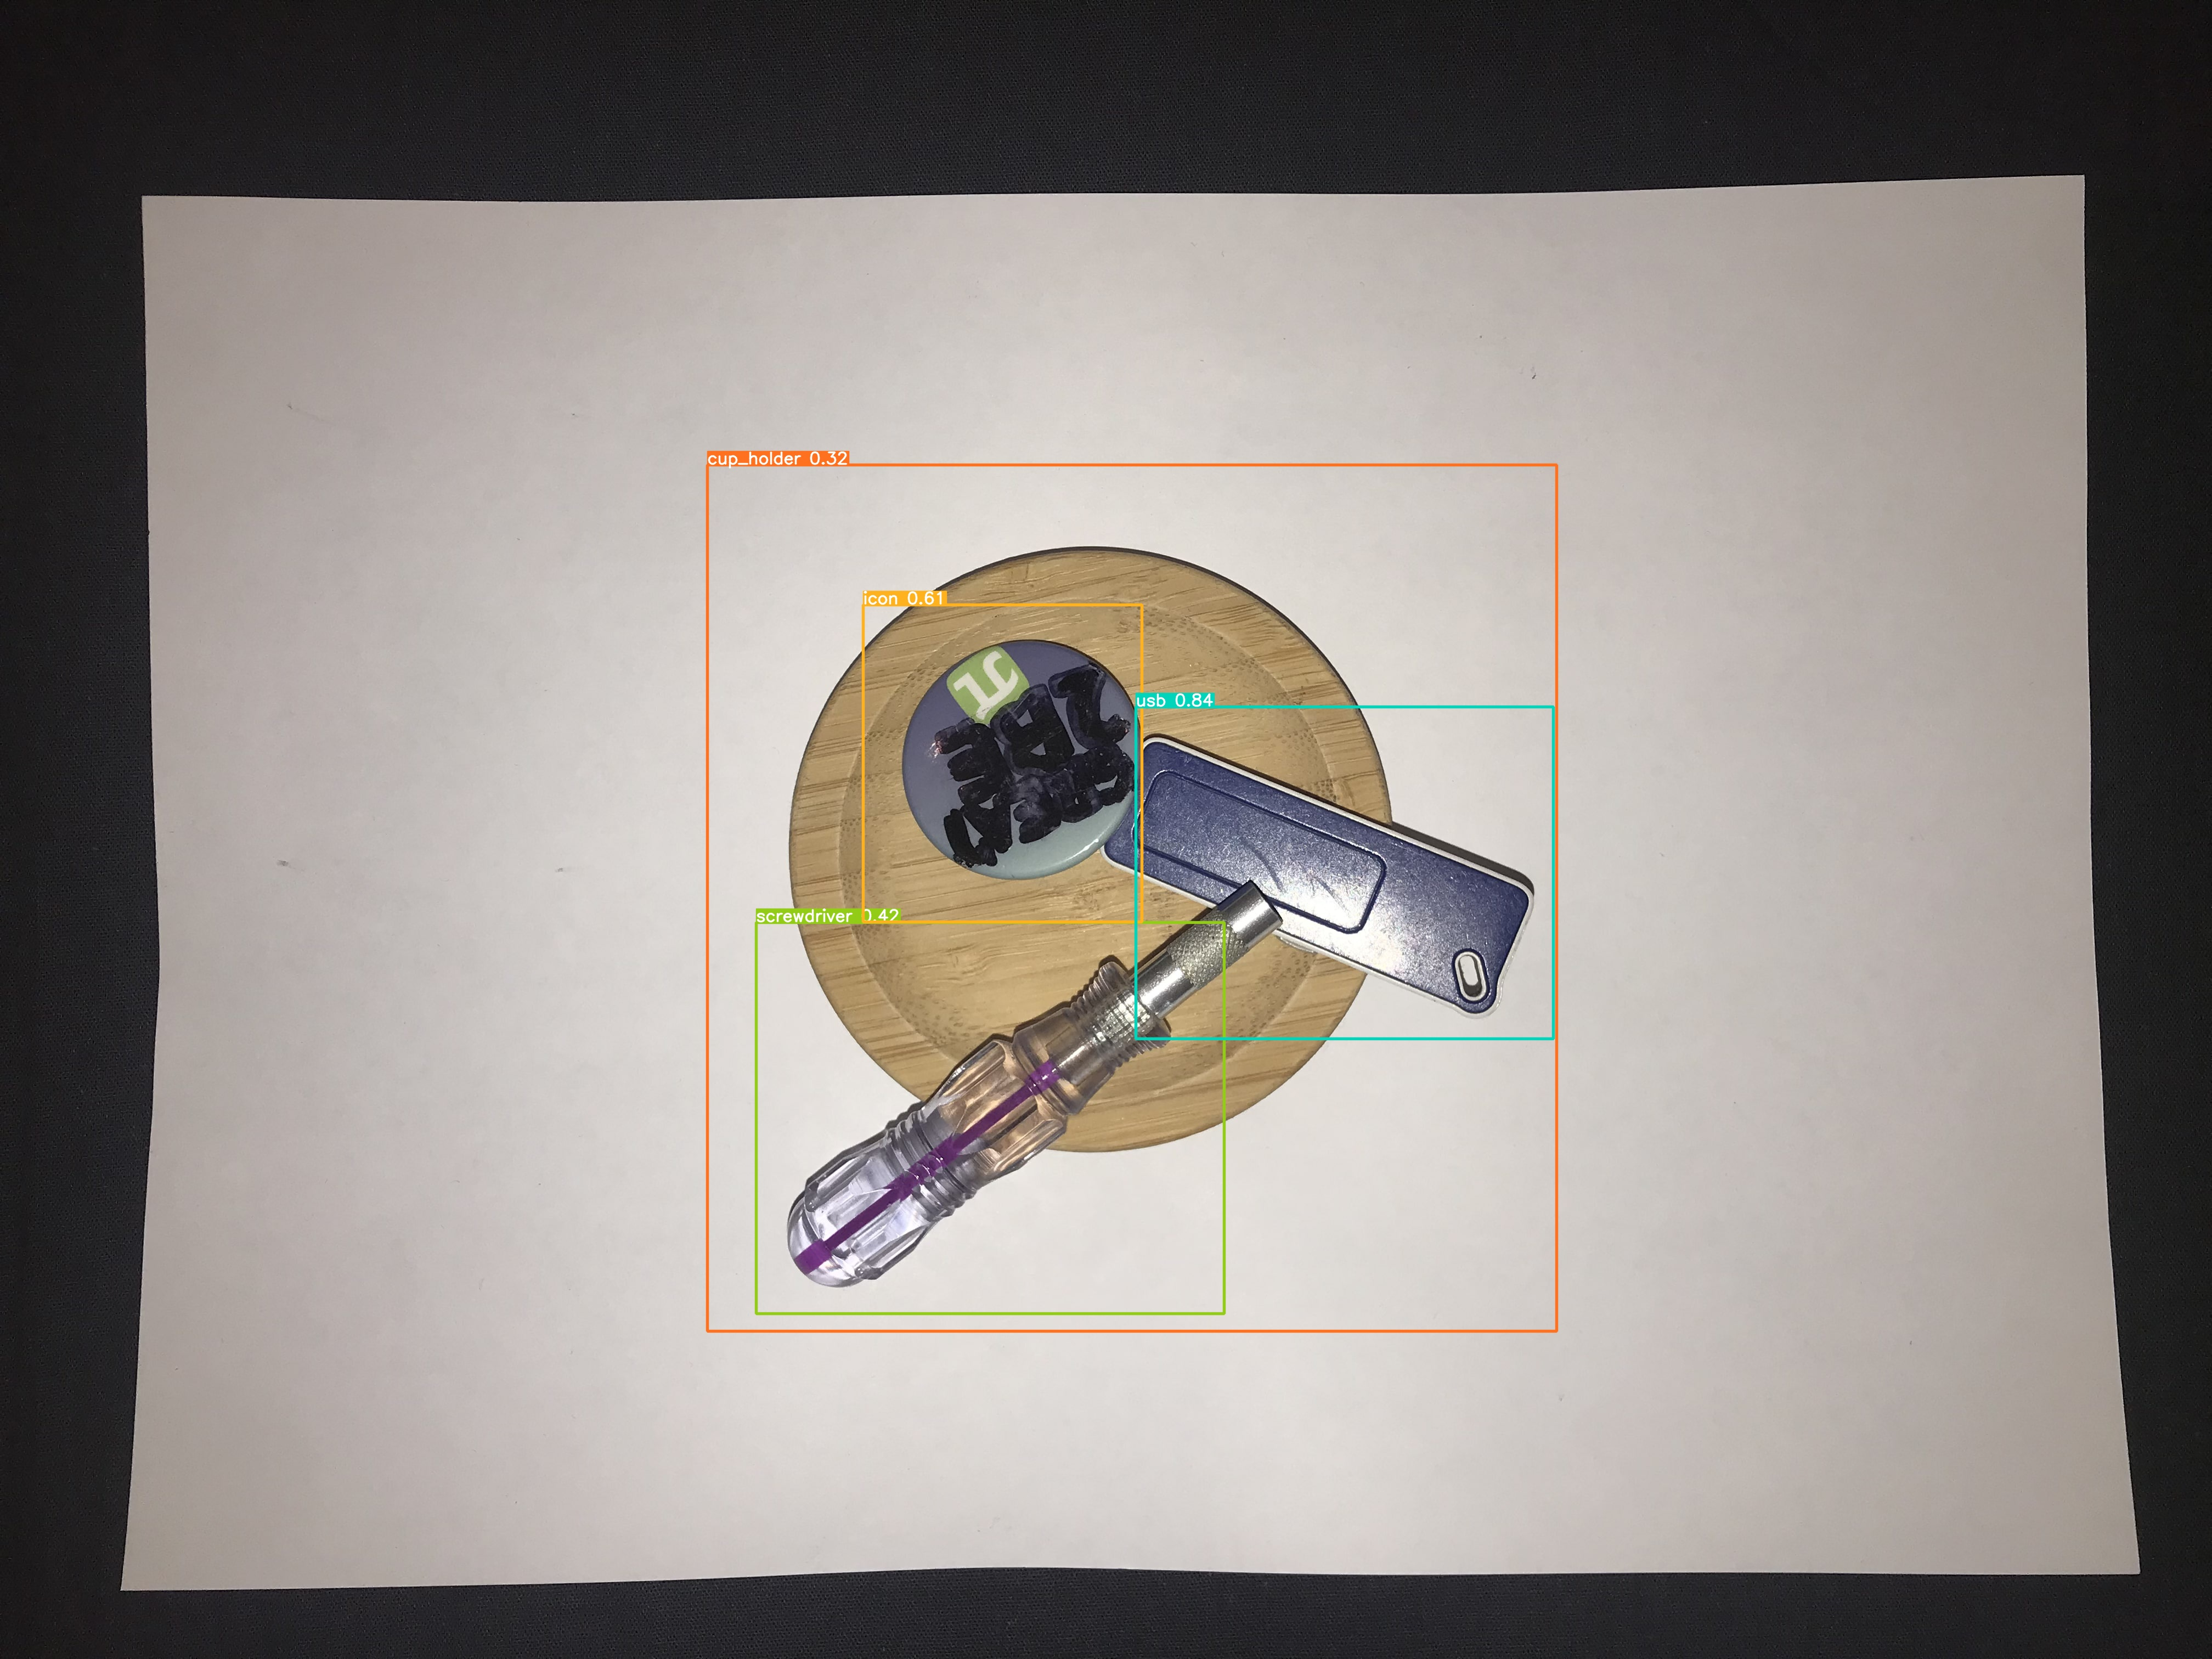

### Предметы известны заранее
Я заренее разметил все контуры и заполнил некоторые метаданные
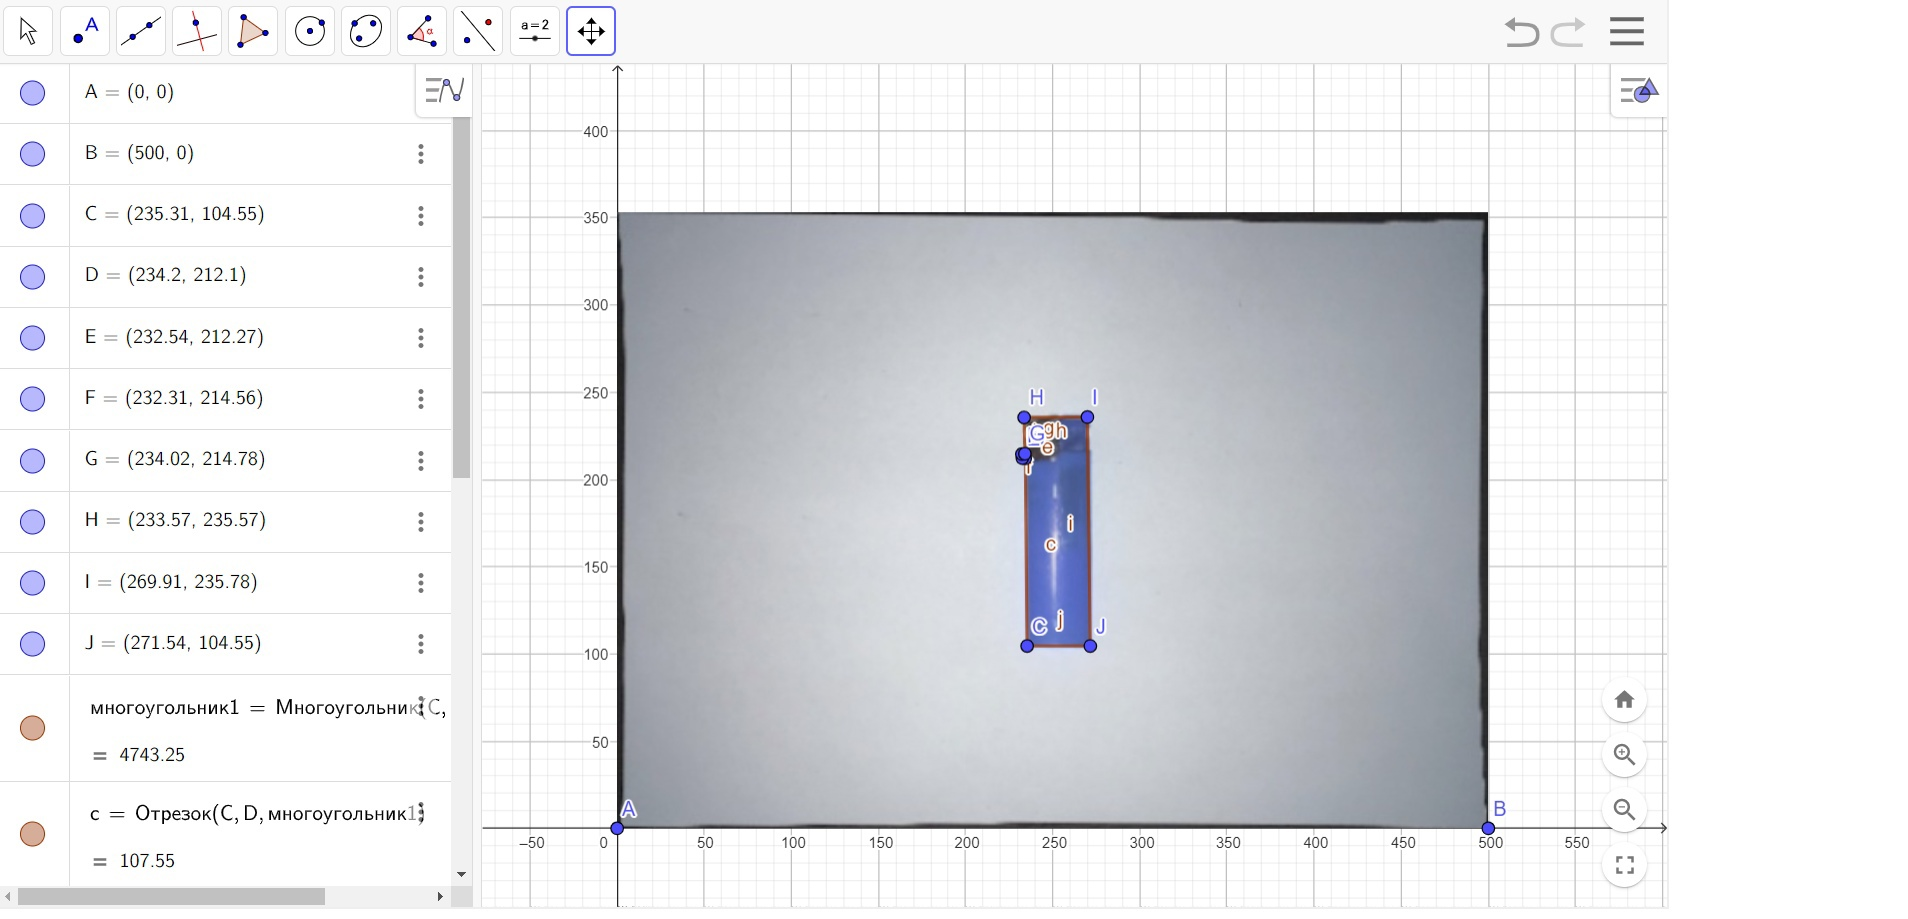

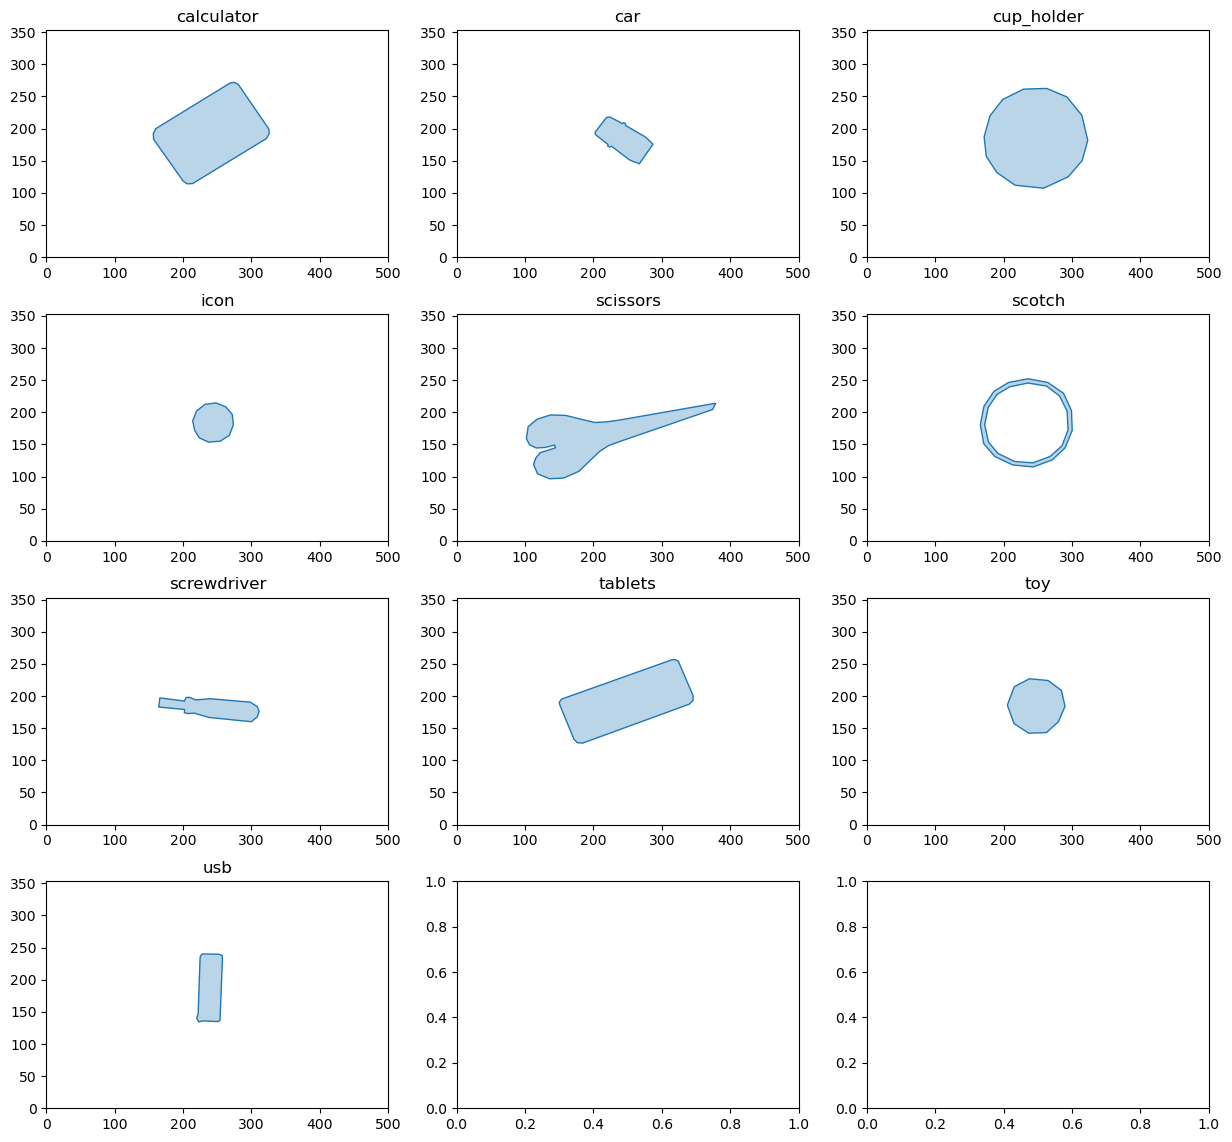

In [3]:
import json
import matplotlib.pyplot as plt
import shapely.geometry
from shapely import Polygon
from shapely.geometry import shape
from shapely import affinity
from shapely.plotting import plot_polygon, plot_line

def get_figure(fig_name: str):
    with open('figures.json', 'r') as f:
        data = json.loads(f.read())
    if fig_name != 'scotch':
        return shape(data[fig_name])
    else:
        return shape(data[fig_name]['outside']).difference(shape(data[fig_name]['inside']))

FiguresCollection = {
    'calculator': get_figure('calculator'),
    'car': get_figure('car'),
    'cup_holder': get_figure('cup_holder'),
    'icon': get_figure('icon'),
    'scissors': get_figure('scissors'),
    'scotch': get_figure('scotch'),
    'screwdriver': get_figure('screwdriver'),
    'tablets': get_figure('tablets'),
    'toy': get_figure('toy'),
    'usb': get_figure('usb')
}

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 14))
plt.subplots_adjust(hspace=0.25)

for figure, ax in zip(FiguresCollection, axs.ravel()):
    geom = FiguresCollection[figure]
    plot_polygon(geom, ax=ax, add_points=False)
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 353)
    ax.set_title(figure)
    
plt.show()

## 2. Идентификация многоугольников


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


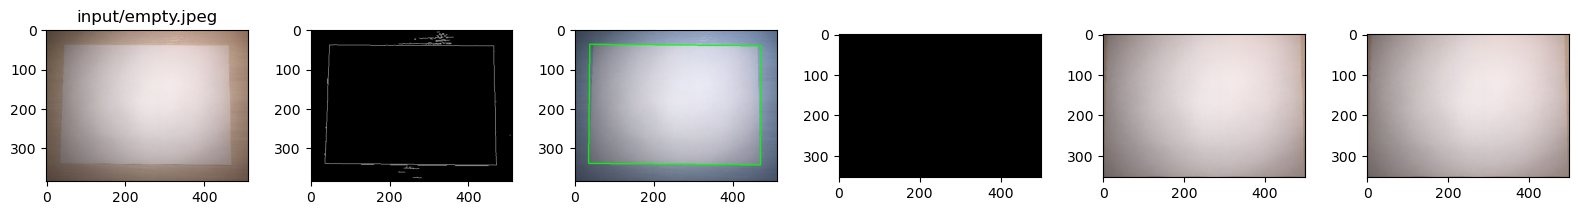

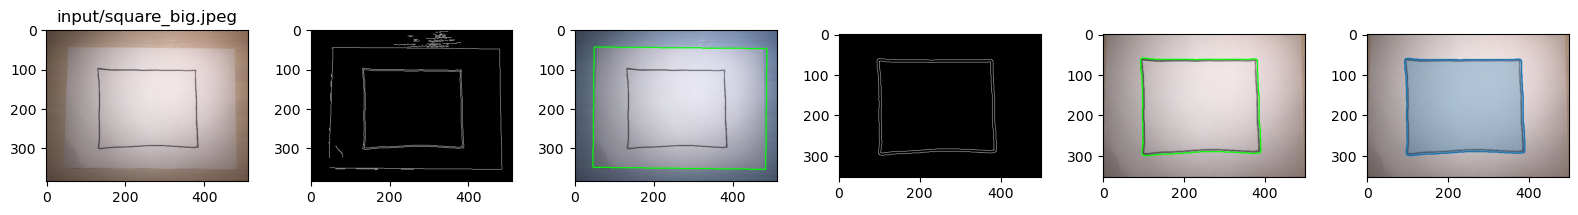

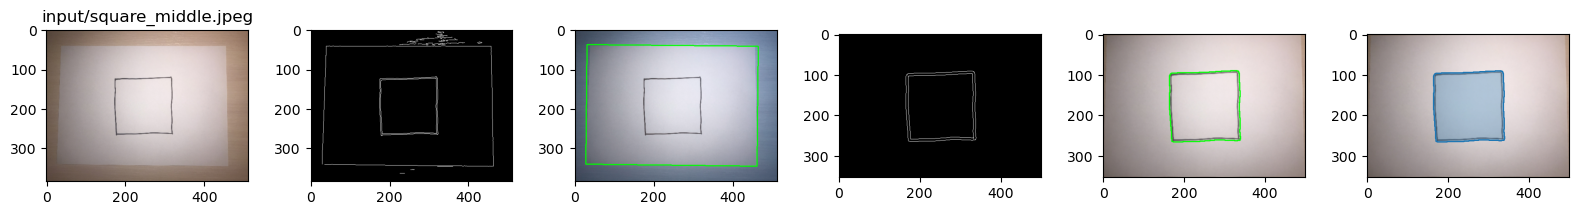

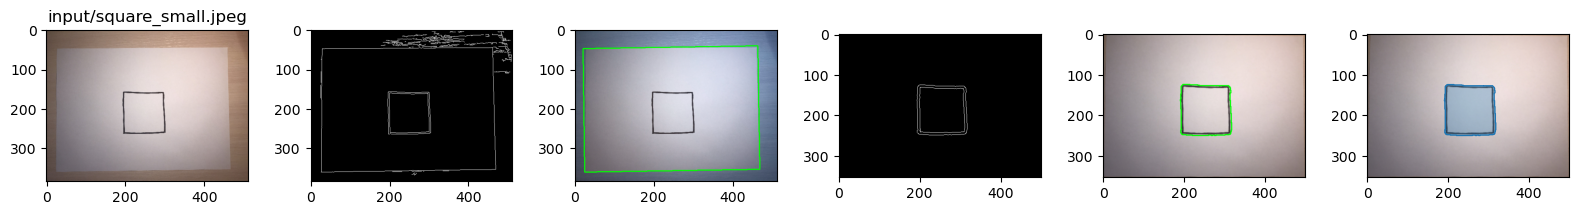

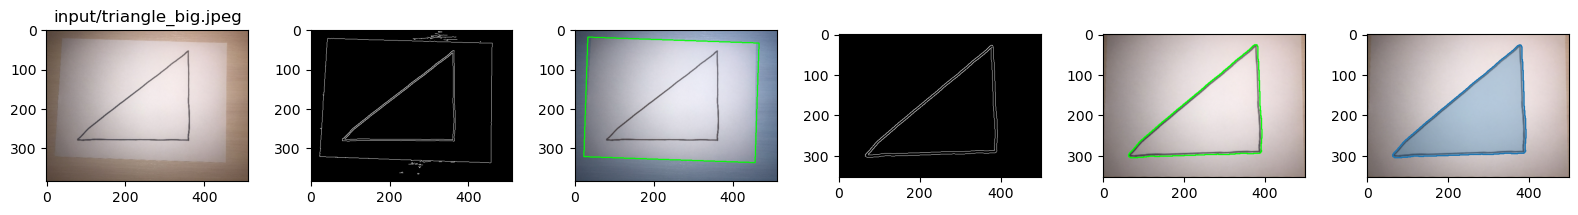

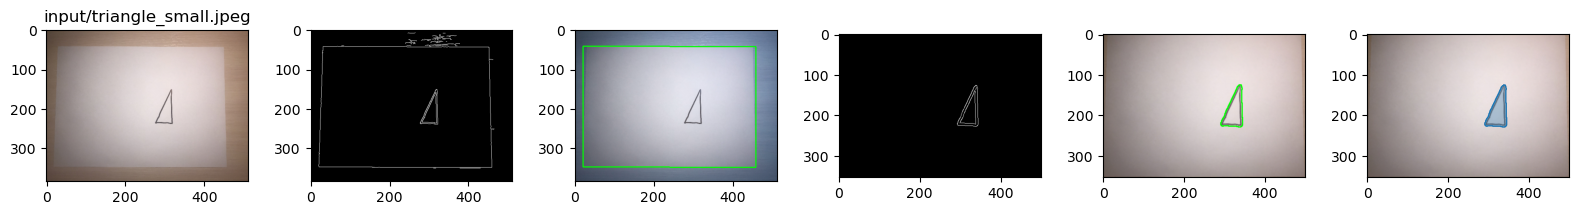

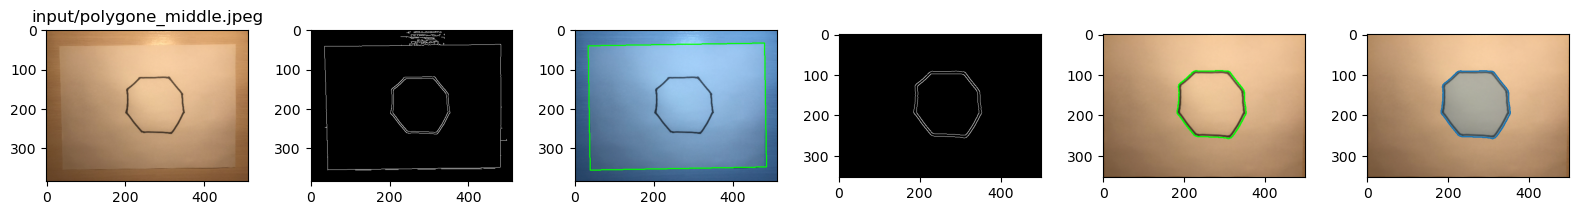

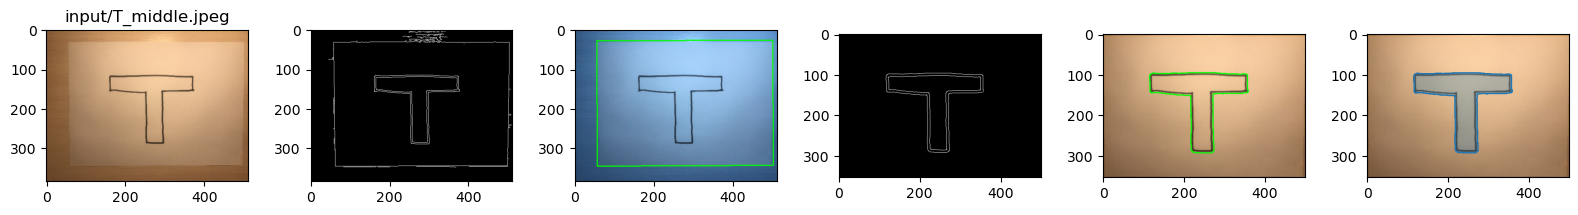

In [4]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

from imageio import imread, imsave
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, corner_harris, corner_peaks, corner_fast, corner_subpix, match_descriptors, ORB
import os

from shapely import Polygon
from shapely.plotting import plot_polygon

polygons = [
    'input/empty.jpeg',
    'input/square_big.jpeg',
    'input/square_middle.jpeg',
    'input/square_small.jpeg',
    'input/triangle_big.jpeg',
    'input/triangle_small.jpeg',
    'input/polygone_middle.jpeg',
    'input/T_middle.jpeg'
]

for path in polygons:
    
    fig, ax = plt.subplots(1, 6)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    fig.tight_layout()
    ax[0].set_title(path)
    
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (512, 384))
    orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayImageBlur = cv2.blur(grayImage, (2, 2))
    edgedImage = cv2.Canny(grayImageBlur, 18, 50)

    allContours = cv2.findContours(edgedImage.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    allContours = imutils.grab_contours(allContours)
    allContours = sorted(allContours, key=cv2.contourArea, reverse=True)
    
    max_perimeter = 0
    paper = None
    for i in range(len(allContours)):
        perimeter = cv2.arcLength(allContours[i], True)
        area = cv2.contourArea(allContours[i])        
        contour = cv2.approxPolyDP(allContours[i], 0.02 * perimeter, True)
        if max_perimeter < perimeter and area > 100_000:
            max_perimeter = perimeter
            paper = contour
    
    if paper is None:
        max_perimeter = 0
        paper_index = 0
        for i in range(len(allContours)):
            perimeter = cv2.arcLength(allContours[i], True)     
            if max_perimeter < perimeter:
                max_perimeter = perimeter
                paper_index = i
        paper = cv2.approxPolyDP(allContours[paper_index], 0.02 * max_perimeter, True)
        
    paper = cv2.minAreaRect(paper)
    paper_box = cv2.boxPoints(paper)
    paper_box = np.int0(paper_box)
    cv2.drawContours(image, [paper_box], 0, (0, 255, 0), 2)
    
    
    paper_box = paper_box.reshape(4,2)
    rect = np.zeros((4,2), dtype="float32")
    s = np.sum(paper_box, axis=1)
    rect[0] = paper_box[np.argmin(s)]
    rect[2] = paper_box[np.argmax(s)]
    diff = np.diff(paper_box, axis=1)
    rect[1] = paper_box[np.argmin(diff)]
    rect[3] = paper_box[np.argmax(diff)]

    (tl, tr, br, bl) = rect

    widthA = np.sqrt((tl[0] -tr[0])**2 + (tl[1] - tr[1])**2 )
    widthB = np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2 )
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2 )
    heightB = np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2 )
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0,0],
        [maxWidth-1, 0],
        [maxWidth-1, maxHeight-1],
        [0, maxHeight-1]], dtype="float32")

    transformMatrix = cv2.getPerspectiveTransform(rect, dst)
    scan = cv2.warpPerspective(orig, transformMatrix, (maxWidth, maxHeight))

    ax[0].imshow(orig)
    ax[1].imshow(edgedImage, cmap='gray')
    ax[2].imshow(image, cmap='gray')
    
    scan = cv2.resize(scan, (500, 353))
    
    ax[3].imshow(scan, cmap='gray')
    
    grayScan = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)
    grayScanBlur = cv2.blur(grayScan, (6, 6))
    edgedScan = cv2.Canny(grayScanBlur, 30, 100)


    ax[3].imshow(edgedScan, cmap='gray')
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.dilate(edgedScan, kernel, iterations=1)
    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    scan_copy = scan.copy()
    cv2.drawContours(scan_copy, contours, -1, (0, 255, 0), 2)
            
    ax[4].imshow(scan_copy)
    
    ax[5].imshow(scan)
    
    if len(contours) > 0:
        contour = np.squeeze(contours[0])
        polygon = Polygon(contour)
        plot_polygon(polygon, ax=ax[5], add_points=False)

### Распознование предметов и многоугольника 

Ultralytics YOLOv8.0.11  Python-3.9.13 torch-1.13.1+cpu CPU
Fusing... 
Model summary: 268 layers, 43614318 parameters, 0 gradients, 164.9 GFLOPs


Исходное изображение предметов:


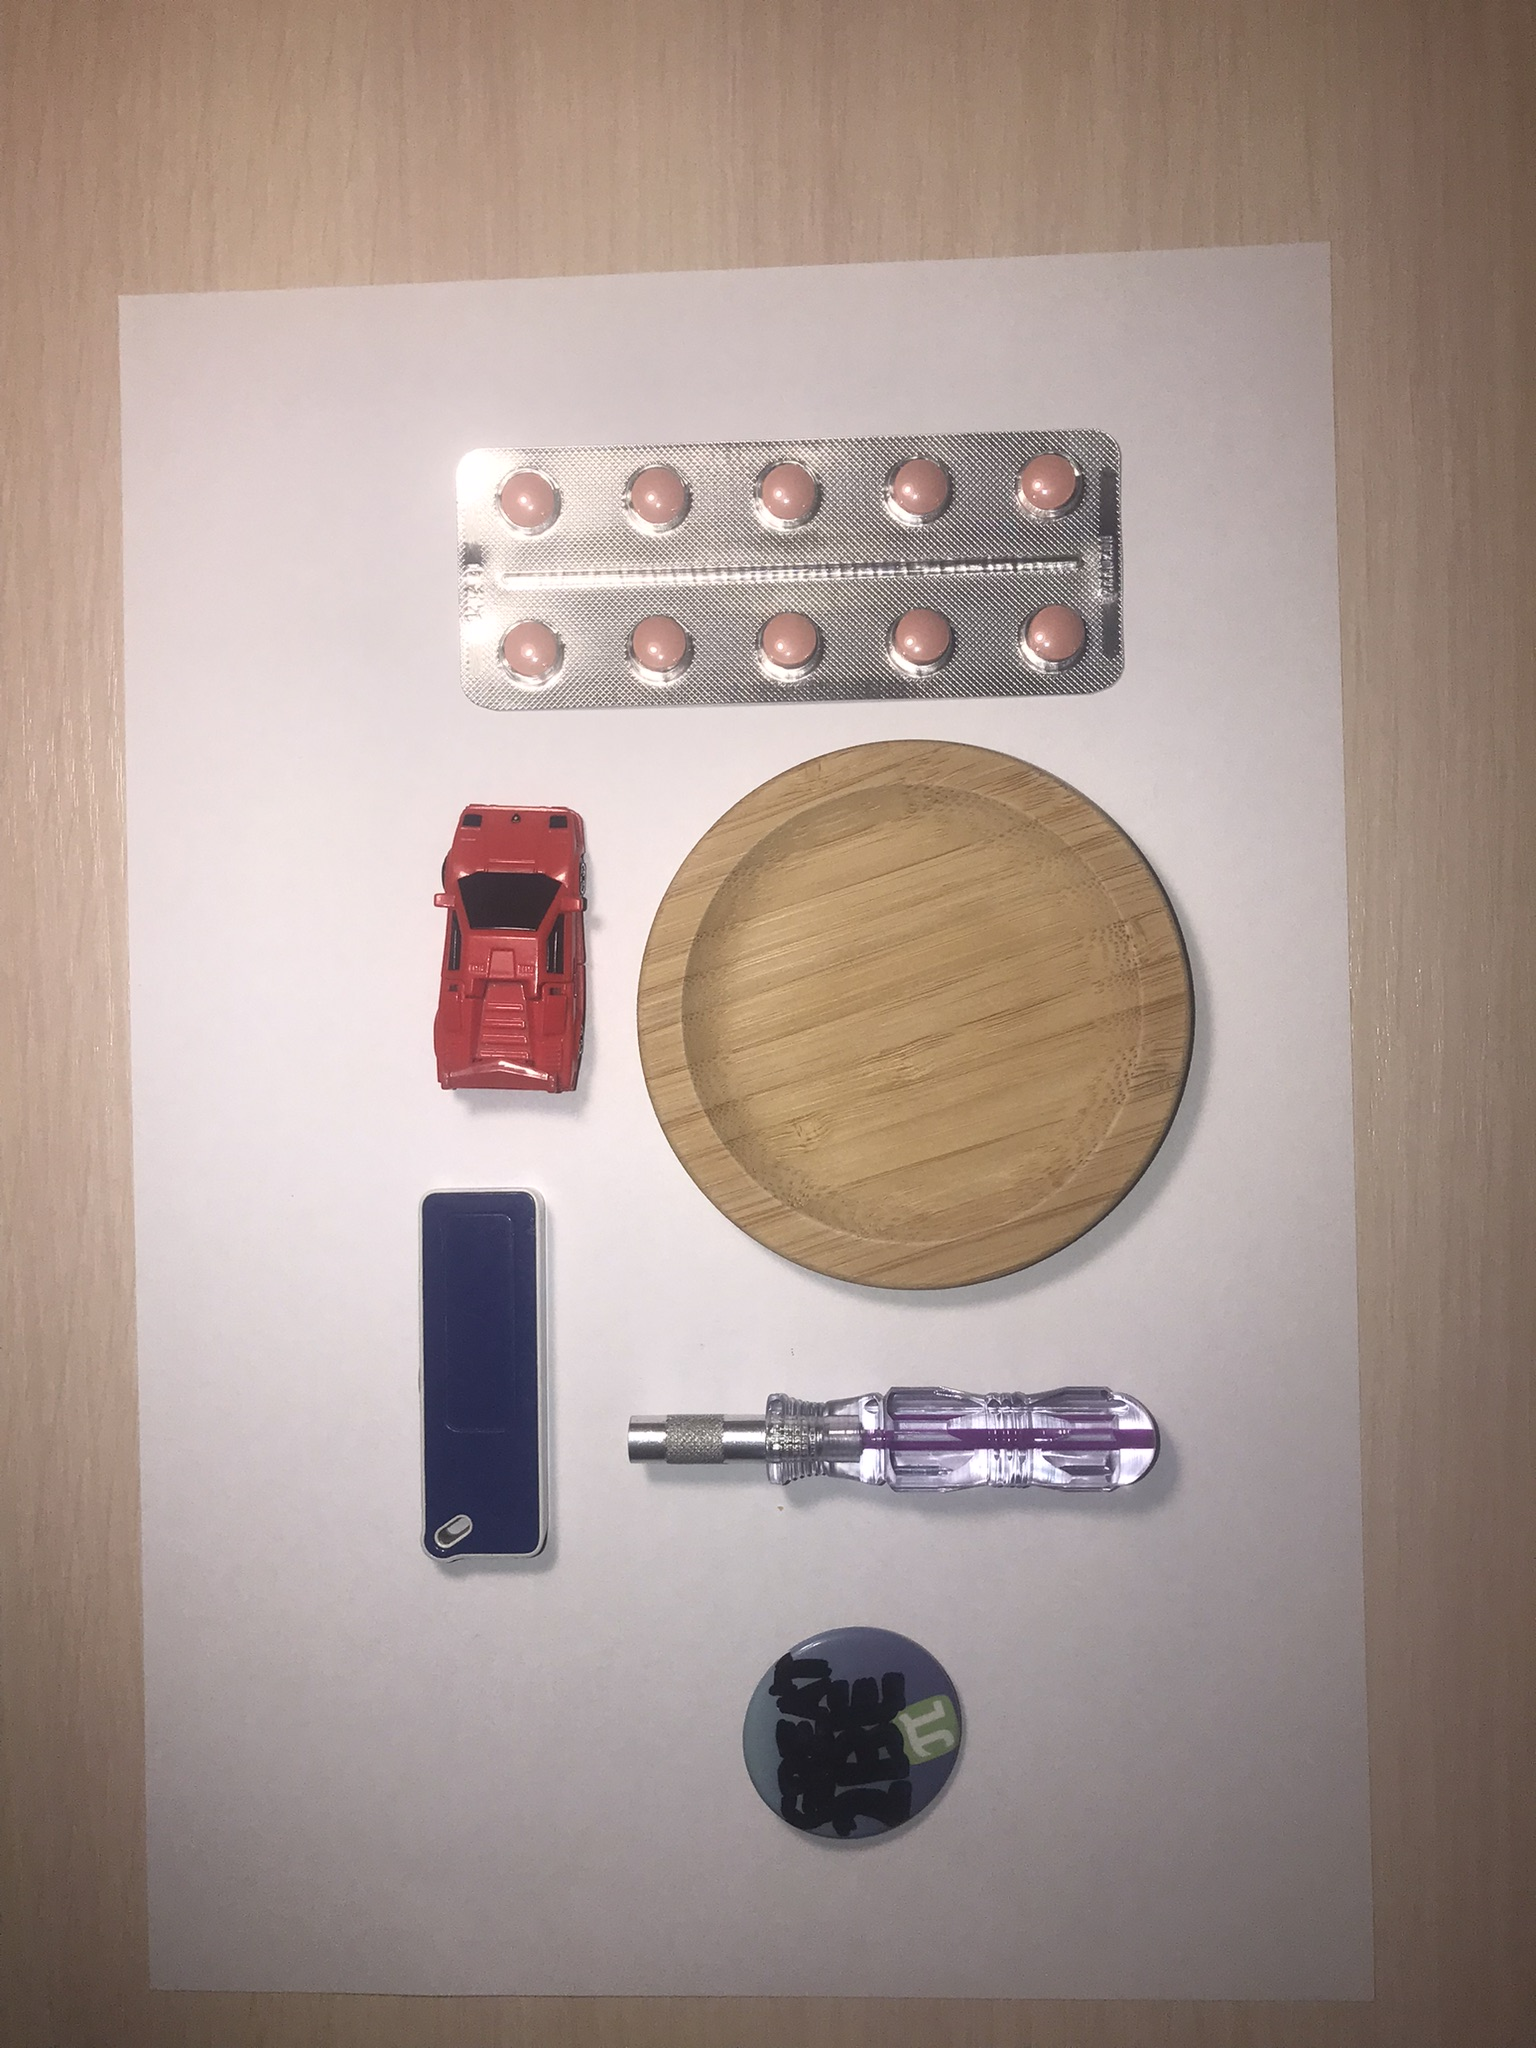

Распознанные предметы:
1) car
2) cup_holder
3) icon
4) screwdriver
5) tablets
6) usb

Исходное изображение многоугольника:


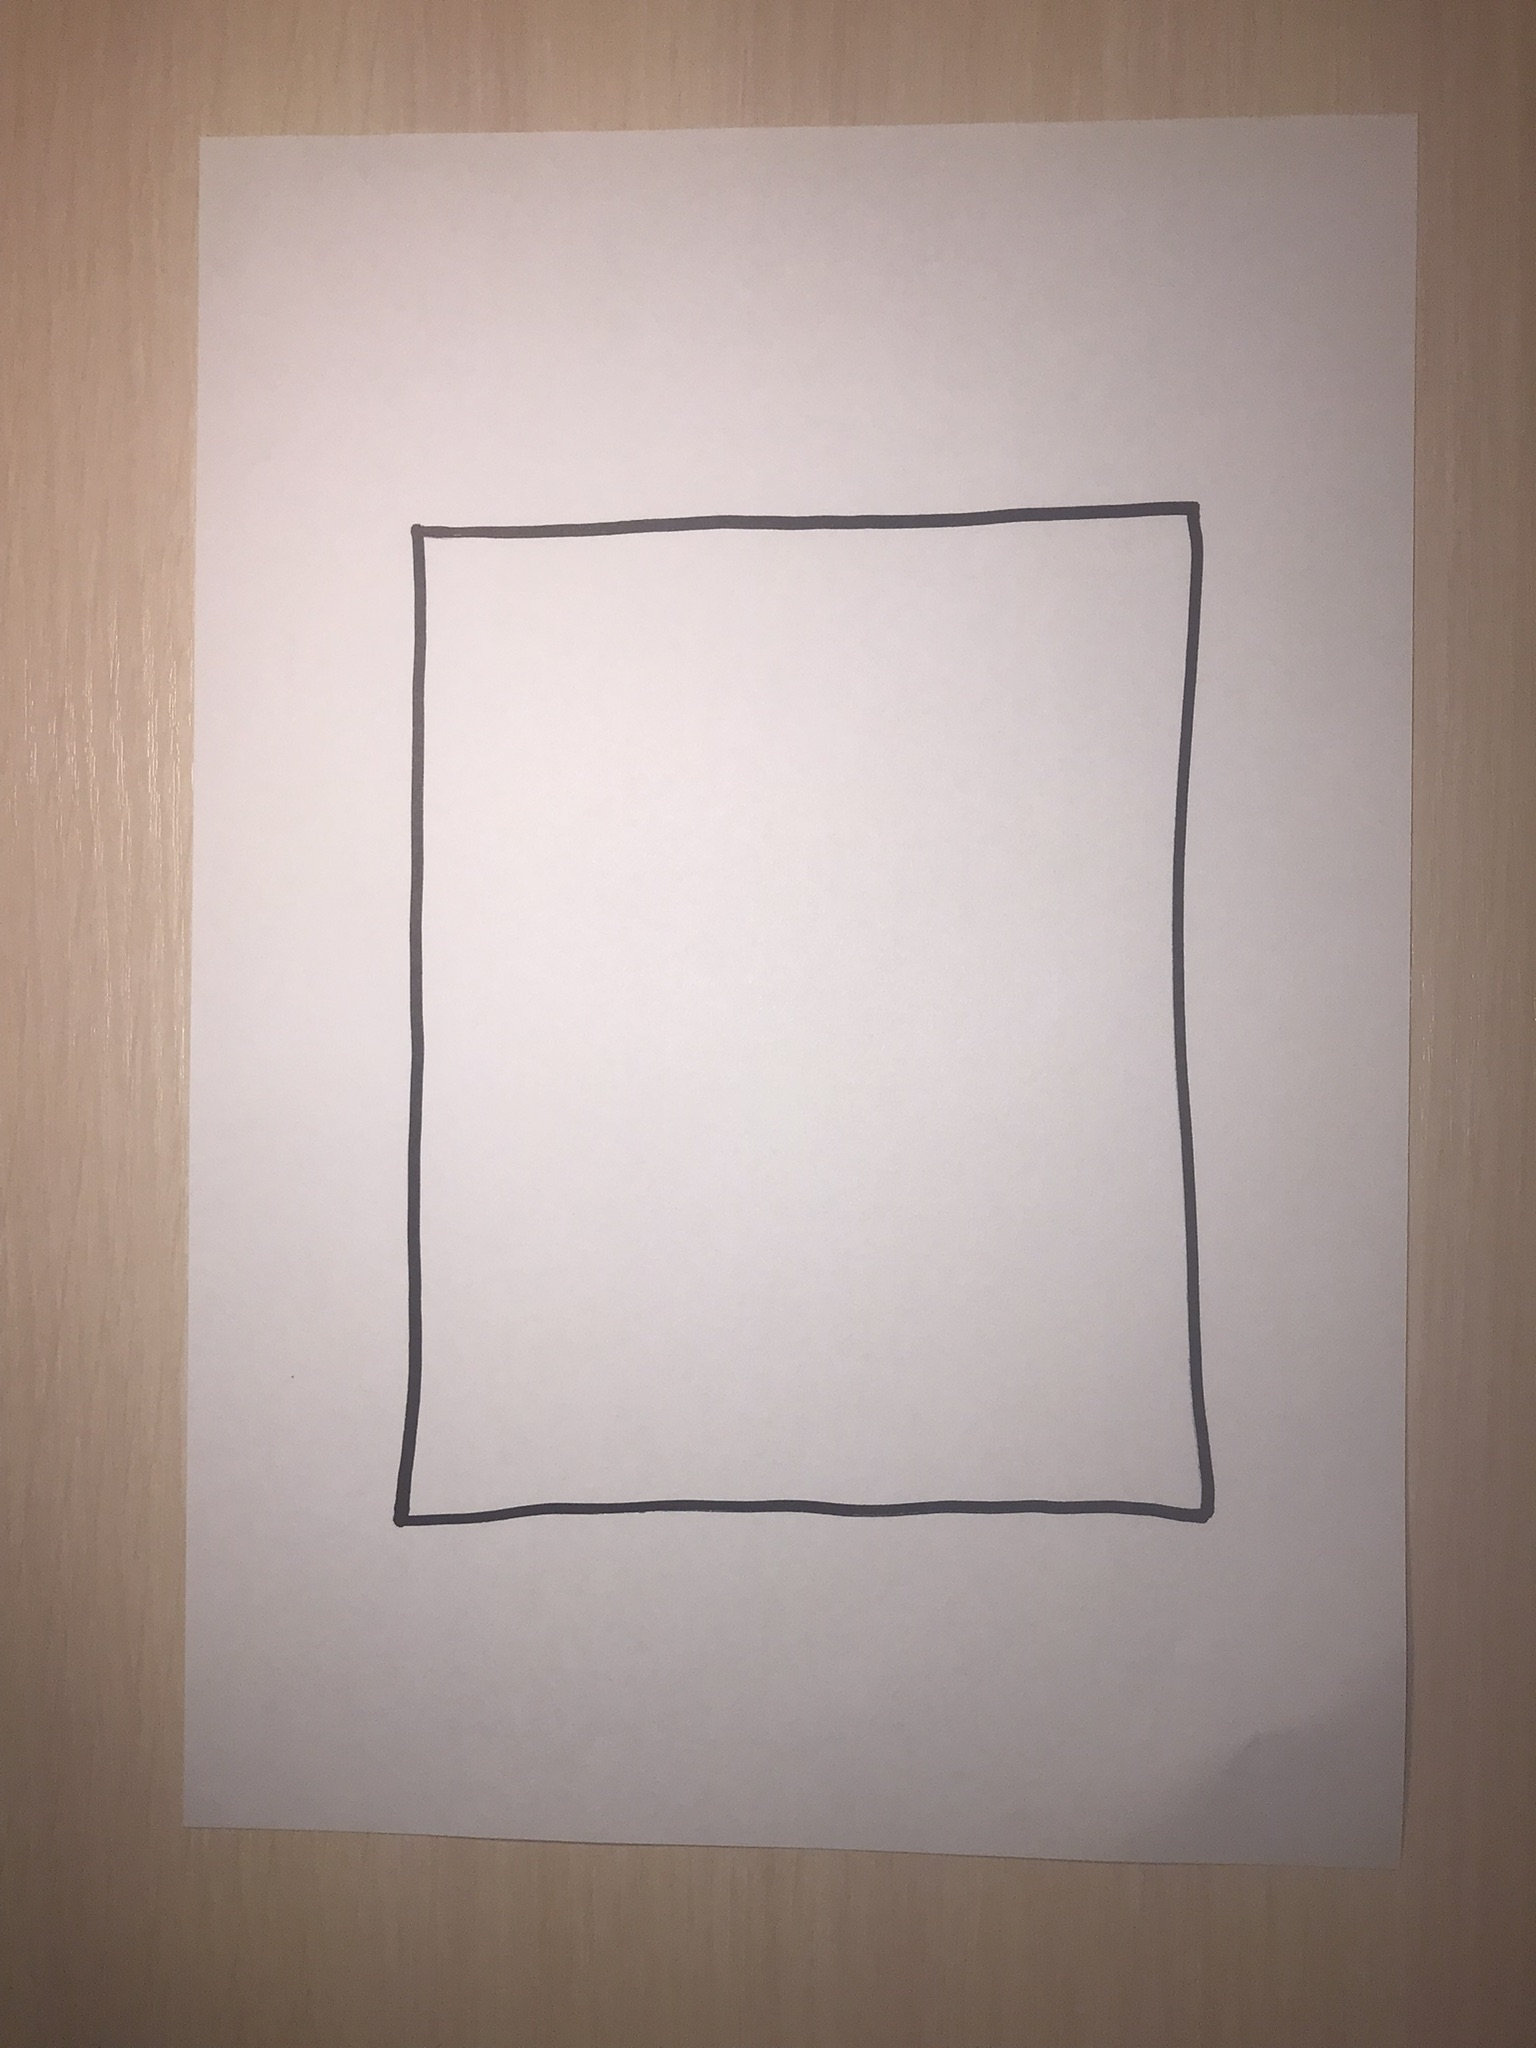

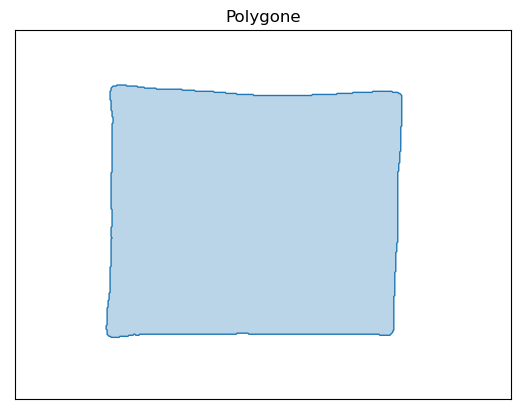

In [5]:
from intelligent_placer_lib import recognize

from IPython.display import Image, display
import matplotlib.pyplot as plt
from shapely.plotting import plot_polygon

image_path = 'input/15.jpeg'
polygone_path = 'input/square_big.jpeg'

items, polygon = recognize(image_path, polygone_path)

print('Исходное изображение предметов:')
display(Image(filename=image_path, width=500))

print('Распознанные предметы:')
for count, item in enumerate(items):
    print(str(count + 1) + ') ' + item.name)

print('\nИсходное изображение многоугольника:')
display(Image(filename=polygone_path, width=500))

fig, ax = plt.subplots()

plot_polygon(polygon, ax=ax, add_points=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(0, 500)
ax.set_ylim(0, 353)
ax.set_title('Polygone')
plt.show()

## 3. Упаковка предметов

Как я планировал сделать:
- **_Проверка необходимых критериев укладки (например, суммарная площадь)_**
- **_Если необходимые условия не сработали, то переходим к основному алгоритму укладки, в основе которого - жадный алгоритм, суммы Минковского и алгоритм доупаковки:_**
  - **_Шаг 1. Сортируем объекты по площади (как именно - открытый вопрос, следует посмотреть на результаты, когда мы подаем предметы по возрастанию площади, убыванию площади и в рандомном порядке)_**
  - **_Шаг 2. Выстраиваем первый объект по эвристическому жадному правилу левого нижнего угла (greedy bottom-left rule)_**
  - **_Шаг 3. Устанавливаем i = 1_**
  - Шаг 4. Вычисляем no-fit polygon для предметов i и (i - 1) с помощью сумму Минковского
  - **_Шаг 5. Располагаем i-й объект по правилу левого нижнего угла, если расположить предмет невозможно, переходим к алгоритму доукладки_**
  - **_Шаг 6. Если кончились предметы, возвращаем True, иначе i = i + 1 и переходим к шагу 4_**
- Если жадный алгоритм не смог уложить все предметы - применяем алгоритм доупаковки (пока в разработке):
  - Можно начать немного двигать предметы, что-то вроде тряски
  - Можно использовать полученный результат, как начальный вектор для работы генетического алгоритма

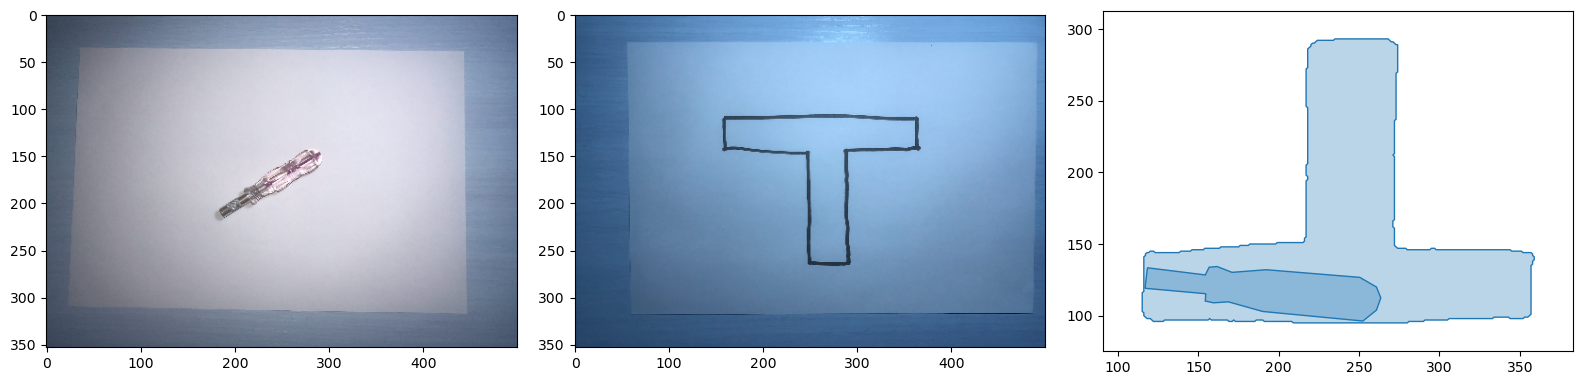

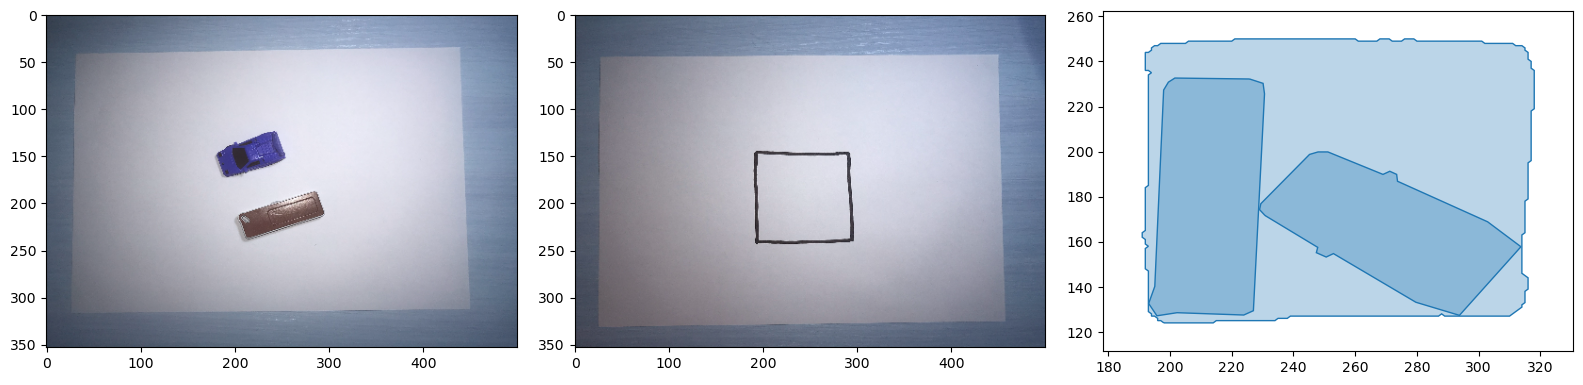

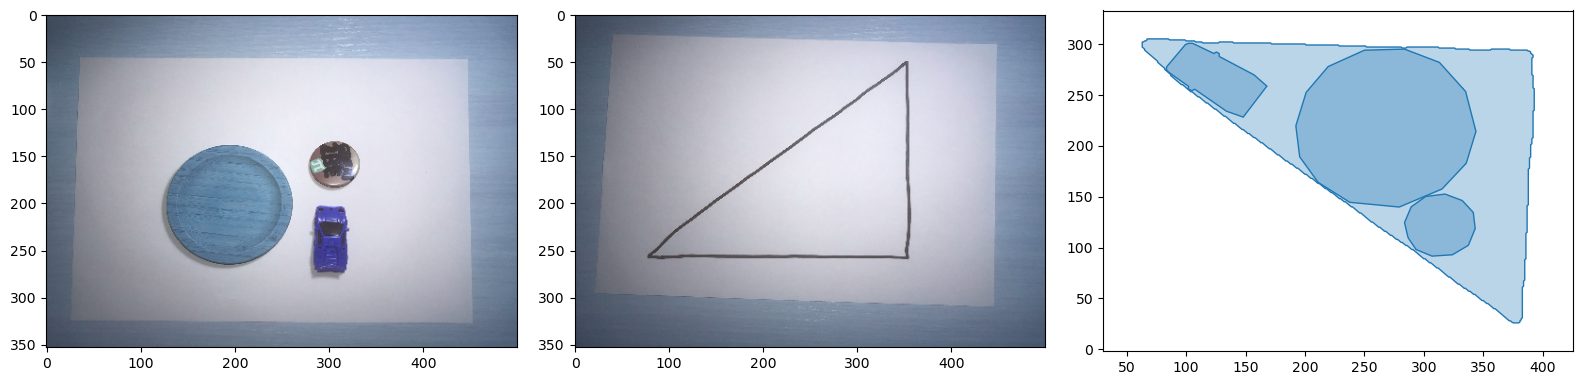

True

In [4]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from intelligent_placer_lib import check_image

check_image('input/07.jpeg', 'input/T_middle.jpeg', draw=True)
check_image('input/08.jpeg', 'input/square_small.jpeg', draw=True)
check_image('input/22.jpeg', 'input/triangle_big.jpeg', draw=True)

In [5]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from intelligent_placer_lib import check_image
import csv

with open('input/meta_items.csv', newline='\n', encoding="utf8") as fp:
    reader = csv.reader(fp, delimiter=";", quotechar='"')
    tests = [row for row in reader][1:]
    
for test in tests:
    print('\nТест №' + test[0])
    print('На фото: ' + test[2])
    res = check_image('input/'+ test[1], 'input/' + test[3], draw=True)
    if (res == True and test[4] == 'True') or (res == False and test[4] == 'False'):
        print('Верно')
    else:
        print('Неверно')


Тест №1
На фото: Машинка, Значок


KeyboardInterrupt: 